In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("/home/yanhu/DddA/DddA/tdac_seq")
from ddda_dataset import *
from utils import *
import os
import re
import seaborn as sns
from itertools import product
import pickle 
from Bio.Seq import Seq
import scipy.stats as ss
import tqdm
import pyranges as pr
%matplotlib inline

In [2]:
# Create a dictionary for reference regions
ref_range_dict = {
    'HJR288': ('chr11', 5245964, 5257447)
}

In [9]:
# Initialize ddda_dataset
replicate = "HJR288_ABE_D10_rep1"
ddda_data = ddda_dataset(
    ID = replicate, 
    region_dict = ref_range_dict, 
    genome_file = "/home/yanhu/data/DddA/shared/refGenomes/hg38.fa", 
    fastq_file = "/home/yanhu/data/DddA/HJR288/fastqs/" + replicate + "/merged.fastq.gz", 
    working_dir = "/home/yanhu/data/DddA/HJR288/"
)

Loading reference genome
Extracting sequences for each locus


In [10]:
# Load DddA bias model
bias_model_path = "/home/yanhu/data/DddA/HJR245/bias_dict.pkl"
ddda_data.load_bias_model(bias_model_path)

# Align reads
gap_threshold = 500
ddda_data.align_reads(
    start_gap_threshold = gap_threshold,
    end_gap_threshold = gap_threshold,
    ABE_edits = True,
    umi_dedup = True, 
    umi_adaptor_1 = "TTTCTGTTGGTGCTGATATTGC", 
    umi_adaptor_2 = "GAAGATAGAGCGACAGGCAAGT", 
    umi_len = 10
)

Computing sequence bias


4811396it [15:49, 5069.94it/s]


838714 reads aligned. 3972682 reads unaligned


In [55]:
locus = "HJR288"
umi_counts = pd.Series(ddda_data.umis[locus]).value_counts()
dup_umi_list = umi_counts[umi_counts == 2].index.values
dup_umis

array(['TCGTTTCATA_TACAAGTGCA', 'CGTAGCGACG_AAACCACTGT',
       'ATATTTGGGG_CAAAAGACAC', 'TTTATCCAAG_AGTTTGATGA',
       'GACGGCCGAA_CACCACGGAA', 'TCCGAACCTA_TCGATGTAAA',
       'GGGGTTTGAG_TATAATTAAC', 'ATTTTCATTT_ATACTACGCA',
       'TTTTTTGTAT_ATAACATAAC', 'TTGCTGCTGC_TTAGAATTGA'], dtype=object)

In [56]:
DddA_matrix = ddda_data.edit_dict[locus]

dup_read_distance = []
for dup_umi in dup_umi_list:
    dup_edit_vec = DddA_matrix[np.array(ddda_data.umis[locus]) == dup_umi, :]
    dup_edit_vec = np.array(dup_edit_vec.todense())
    distance = np.sum(np.abs(dup_edit_vec[0, :] - dup_edit_vec[1, :]))
    dup_read_distance.append(distance)

bg_read_distance = []
for i in range(1000):
    sample_inds = np.random.randint(0,len(ddda_data.umis[locus]), 2)
    dup_edit_vec = DddA_matrix[sample_inds, :]
    dup_edit_vec = np.array(dup_edit_vec.todense())
    distance = np.sum(np.abs(dup_edit_vec[0, :] - dup_edit_vec[1, :]))
    bg_read_distance.append(distance)

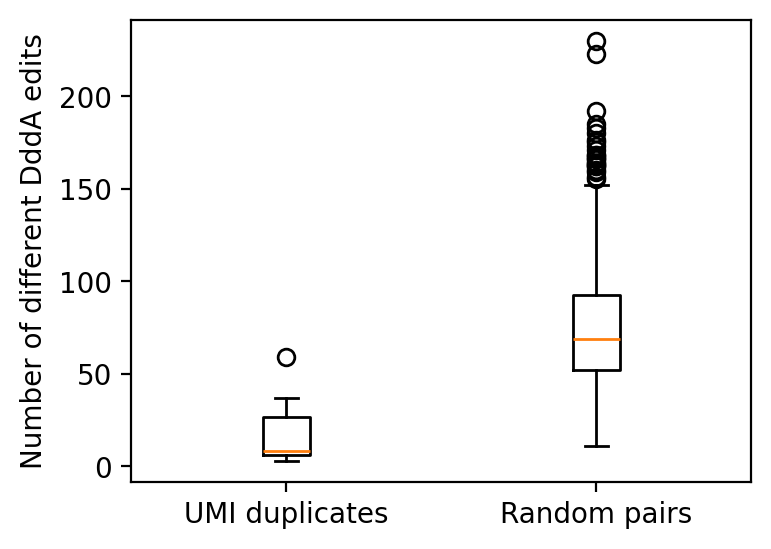

In [65]:
fig, ax = plt.subplots(1, 1, dpi=200, figsize=(4,3))
ax.boxplot(
    [dup_read_distance, bg_read_distance])
ax.set_xticklabels(['UMI duplicates', "Random pairs"])
ax.set_ylabel("Number of different DddA edits")
plt.show()

In [133]:
fastq_file = "/home/yanhu/data/DddA/HJR288/fastqs/HJR288_ABE_D10_rep1/merged.subsample.fastq.gz"
start_gap_threshold = 500
end_gap_threshold = 500
mask_CpG = True
ABE_edits = True
del_size_threshold = 5
read_seqs = []
adaptor_match_result = []
forward_matched = 0
reverse_matched = 0
counter = 0
for read_id, read_seq, qual in get_fastq_iter(fastq_file):
    umi_adaptor_1 = "TTTCTGTTGGTGCTGATATTGC"
    umi_adaptor_1_rc = str(Seq(umi_adaptor_1).reverse_complement())
    umi_adaptor_2 = "GAAGATAGAGCGACAGGCAAGT"
    umi_adaptor_2_rc = str(Seq(umi_adaptor_2).reverse_complement())
    adaptors = [umi_adaptor_1, umi_adaptor_1_rc, umi_adaptor_2, umi_adaptor_2_rc]
    adaptor_matches = [read_seq.find(i) for i in adaptors]
    match_flags = [i > 0 for i in adaptor_matches]
    adaptor_match_result.append(match_flags)
    if match_flags == [0, 1, 0, 1]:
        forward_matched += 1
        
        aligner = mappy.Aligner(ref_fasta_path, preset='map-ont')
        
        # Align the current read
        alignments = [a for a in aligner.map(read_seq, cs=True)]

        # Remove multi-mappers and unmapped reads
        if len(alignments) == 0 or len(alignments) > 1:
            continue
        else:
            alignment = alignments[0]
        
        # Retrieve the locus that this read is aligned to
        locus = alignment.ctg
        seq_len = len(ref_seq_dict[locus])
        
        # Remove reads with large gaps at the beginning or end
        if alignment.r_st >= start_gap_threshold:
            print("Low locus coverage")
        if alignment.r_en <= seq_len - end_gap_threshold:
            print("Low locus coverage")
        
        # Parse information from the cs string (for details see https://lh3.github.io/minimap2/minimap2.html)
        cs_info = re.findall("([=:*+-~][\\dATCGNatcgn]+)", alignment.cs)
        
        # Encode C-to-T mutations and G-to-A mutations into a vector
        edit_vec = np.zeros((seq_len, 2))
        del_vec = np.zeros(seq_len)
        ABE_edit_vec = np.zeros(seq_len)
        current_pos = alignment.r_st
        ref_seq = ref_seq_dict[locus]
        for i in cs_info:
            match i[0]:
                case ":":  # Match compared to the reference
                    current_pos = current_pos + int(i[1:])
                case "-":  # Deletion compared to the reference
                    del_size = len(i[1:])
                    if del_size > del_size_threshold:  # Record deletions passing size threshold
                        del_vec[current_pos:(current_pos + del_size)] = 1
                    current_pos = current_pos + del_size
                case "+":  # Insertion compared to the reference
                    pass
                case "*":  # Mismatch compared to the reference
                    if mask_CpG:
                        is_CpG = (ref_seq[current_pos:(current_pos + 2)] == "CG") or \
                        (ref_seq[(current_pos - 1):(current_pos + 1)] == "CG")
                    else:
                        is_CpG = False # IF we don't mask CpG, just treat every CpG as non-CpG
                    if i[1] == "c" and i[2] == "t" and not is_CpG:
                        edit_vec[current_pos, 0] = 1
                    if i[1] == "g" and i[2] == "a" and not is_CpG:
                        edit_vec[current_pos, 1] = 1
                    if ABE_edits:
                        if (i[1] == "a" and i[2] == "g") or (i[1] == "t" and i[2] == "c"):
                            ABE_edit_vec[current_pos] = 1                    
                    current_pos = current_pos + 1
        
        # Determine if the current read is a C-to-T strand or G-to-A strand
        strand_ind = np.argmax(np.sum(edit_vec, axis=0))
        
        # Also mask read edges because different reads have different edge gaps
        edit_vec[:start_gap_threshold] = 0
        edit_vec[-end_gap_threshold:] = 0
        if ABE_edits:
            ABE_edit_vec[:start_gap_threshold] = 0
            ABE_edit_vec[-end_gap_threshold:] = 0
            
        counter += 1
        if counter == 800:
            break
    
    if match_flags == [1, 0, 1, 0]:
        reverse_matched += 1       
    read_seqs.append(read_seq)
    if len(read_seqs) == 20000:
        break
adaptor_match_result = np.array(adaptor_match_result) > 0

Low locus coverage
Low locus coverage
Low locus coverage
Low locus coverage
Low locus coverage


In [134]:
len(read_seq)

11681

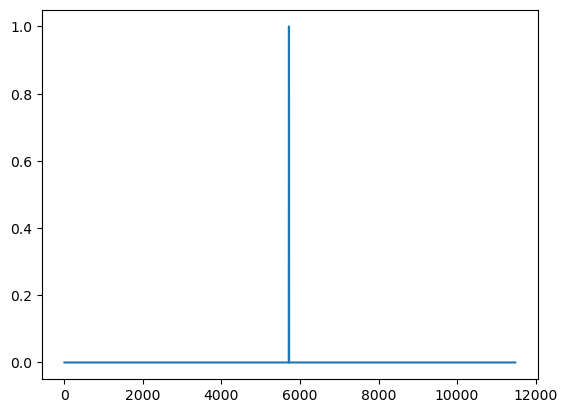

In [135]:
plt.plot(del_vec)

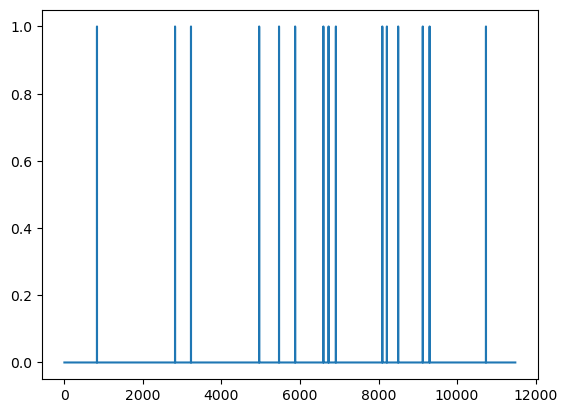

In [136]:
plt.plot(ABE_edit_vec)

In [137]:
adaptor_matches

[-1, 11635, -1, 74]

In [145]:
pos_1 = adaptor_matches[1] # First matched base position of adaptor 1
umi_len = 10
adaptor_1_len =len(umi_adaptor_1)
umi_adaptor_2
print(str(Seq(read_seq[pos_1:(pos_1 + adaptor_1_len)]).reverse_complement()))
print(str(Seq(read_seq[(pos_1 - umi_len):pos_1]).reverse_complement()))
print(str(Seq(read_seq[(pos_1 - 30):(pos_1 - umi_len)]).reverse_complement()))

TTTCTGTTGGTGCTGATATTGC
GGGGGCGGTG
ACACTCTTTCCCTACACGAC


In [149]:
pos_2 = adaptor_matches[3] # First matched base position of adaptor 1
adaptor_2_len =len(umi_adaptor_2)
print(str(Seq(read_seq[pos_2:(pos_2 + adaptor_2_len)]).reverse_complement()))
print(str(Seq(read_seq[(pos_2 + adaptor_2_len):(pos_2 + adaptor_2_len + umi_len)]).reverse_complement()))
print(str(Seq(read_seq[(pos_2 + adaptor_2_len + umi_len):(pos_2 + adaptor_2_len + 30)]).reverse_complement()))

GAAGATAGAGCGACAGGCAAGT
GTCGGTGCCG
AGAAGCTGAAATAGTAAATT


In [132]:
pos_2 = adaptor_matches[2] # First matched base position of adaptor 1
umi_2 = read_seq[(pos_2 - umi_len):pos_2]
print(read_seq[pos_2:(pos_2 + len(umi_adaptor_2))])
print(read_seq[(pos_2 - umi_len):pos_2])
print(read_seq[(pos_2 - 30):(pos_2 - umi_len)])

GAAGATAGAGCGACAGGCAAGT
CCCGCACACC
AGAAGCTGAAATAGTAAATT


In [93]:
ref_fasta_path = "/home/yanhu/data/DddA/HJR288/ref.fa"
ref_seq_dict = {}
with open(ref_fasta_path, "rt") as ref_fasta:
    while (line := ref_fasta.readline()):
        assert line[0] == ">", "Invalid fasta file"
        locus = line[1:].strip()
        ref_seq = ref_fasta.readline().strip()
        ref_seq_dict[locus] = ref_seq

[]

In [94]:
aligner = mappy.Aligner(ref_fasta_path, preset='map-ont')

# Align the current read
alignments = [a for a in aligner.map(read_seq, cs=True)]
alignment = alignments[0]

# Retrieve the locus that this read is aligned to
locus = alignment.ctg
seq_len = len(ref_seq_dict[locus])

# Remove reads with large gaps at the beginning or end
if alignment.r_st >= start_gap_threshold:
    print("Low locus coverage")
if alignment.r_en <= seq_len - end_gap_threshold:
    print("Low locus coverage")

# Parse information from the cs string (for details see https://lh3.github.io/minimap2/minimap2.html)
cs_info = re.findall("([=:*+-~][\\dATCGNatcgn]+)", alignment.cs)

# Encode C-to-T mutations and G-to-A mutations into a vector
edit_vec = np.zeros((seq_len, 2))
del_vec = np.zeros(seq_len)
ABE_edit_vec = np.zeros(seq_len)
current_pos = alignment.r_st
ref_seq = ref_seq_dict[locus]
for i in cs_info:
    match i[0]:
        case ":":  # Match compared to the reference
            current_pos = current_pos + int(i[1:])
        case "-":  # Deletion compared to the reference
            del_size = len(i[1:])
            if del_size > del_size_threshold:  # Record deletions passing size threshold
                del_vec[current_pos:(current_pos + del_size)] = 1
            current_pos = current_pos + del_size
        case "+":  # Insertion compared to the reference
            pass
        case "*":  # Mismatch compared to the reference
            if mask_CpG:
                is_CpG = (ref_seq[current_pos:(current_pos + 2)] == "CG") or \
                (ref_seq[(current_pos - 1):(current_pos + 1)] == "CG")
            else:
                is_CpG = False # IF we don't mask CpG, just treat every CpG as non-CpG
            if i[1] == "c" and i[2] == "t" and not is_CpG:
                edit_vec[current_pos, 0] = 1
            if i[1] == "g" and i[2] == "a" and not is_CpG:
                edit_vec[current_pos, 1] = 1
            if ABE_edits:
                if (i[1] == "a" and i[2] == "g") or (i[1] == "t" and i[2] == "c"):
                    ABE_edit_vec[current_pos] = 1                    
            current_pos = current_pos + 1

# Determine if the current read is a C-to-T strand or G-to-A strand
strand_ind = np.argmax(np.sum(edit_vec, axis=0))

# Also mask read edges because different reads have different edge gaps
edit_vec[:start_gap_threshold] = 0
edit_vec[-end_gap_threshold:] = 0
if ABE_edits:
    ABE_edit_vec[:start_gap_threshold] = 0
    ABE_edit_vec[-end_gap_threshold:] = 0

IndexError: list index out of range

In [82]:
np.sum((adaptor_match_result[:, 0] == 0) & \
    (adaptor_match_result[:, 1] == 1) & \
    (adaptor_match_result[:, 2] == 0) & \
    (adaptor_match_result[:, 3] == 1))

3094

In [54]:
forward_matched = np.sum(adaptor_match_result[:, 0] > 0, axis=1)
reverse_matched = np.sum(adaptor_match_result[:, [1,3]] > 0, axis=1)

In [56]:
np.sum(forward_matched == 2)

3275

In [57]:
np.sum(reverse_matched == 2)

3104

In [61]:
np.sum(np.sum(adaptor_match_result[:, [1,3]] > 0, axis=1) == 2)

3104

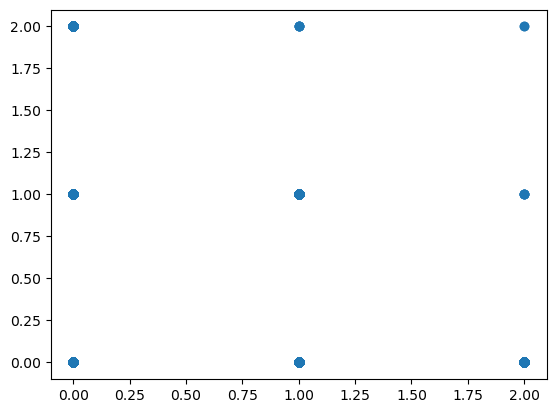

In [23]:
plt.scatter(np.sum(adaptor_match_result[:, :2] > 0, axis=1), np.sum(adaptor_match_result[:, 2:] > 0, axis=1))